<B>Mengimpor library dan datasheets<B>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ann-car-sales-price-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2515235%2F4268549%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T020943Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ccac9b43ad08b1fd04e00e8331a35301b5b743d51754e76767e36bd50db38d529f92a7c43fc18e5a7ca014304d59a34086813685226c99b109231c592f9390264400d77d24c454adccdd8521e8804bb2ce49cfdd38a6316ba33f820a8f34f42b6f2ac8e432141f72f7b4b2d612be4dcaeb995140af5350d0f44cf23da307f8991e8c69a899c93bf5b471ac6100bfd8087af7bfe4da9bc32179c7a506c996e42e11136594aced8f2bc5c66da91cea9c78f5277dc90f4672575d275007a1c6192f8ec4728f2e445930cc00c580b40b869b2fd130320c03341b08027ffb93356e515f71f1e3a47086d738688a236ba2316675b837baf99e7f6cb2326590af9f4a1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29716 bytes downloaded
Downloaded and uncompressed: ann-car-sales-price-prediction
Data source import complete.


# Importing necessary libraries

**Mengimpor Library**




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report

Menampilkan 5 data pertama dari file csv yang telah kita download

In [ ]:
df = pd.read_csv('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', encoding='ISO-8859-1')
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


Menghapus kolom yang tidak diperlukan, yaitu


*   Nama Pembeli
*   Email pembeli
*   Negara
*   Jenis kelamin





In [ ]:
df.drop(columns=['customer name', 'customer e-mail', 'country', 'gender'], inplace=True)

Menampilkan data baru yang berisi data yang diperlukan saja

In [ ]:
df.head()

,age,annual Salary,credit card debt,net worth,car purchase amount
0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


Mempelihatkan jumlah data yang yang tidak null(tidak diketahui) dan tipe setiap data

In [ ]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  500 non-null    float64
 1   annual Salary        500 non-null    float64
 2   credit card debt     500 non-null    float64
 3   net worth            500 non-null    float64
 4   car purchase amount  500 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64

Membuat sebuah plot sebar hubungan antara gaji tahunan dan hutang kartu kredit dari data

Text(0.5, 1.0, 'the corr between credit card debt and annual Salary')

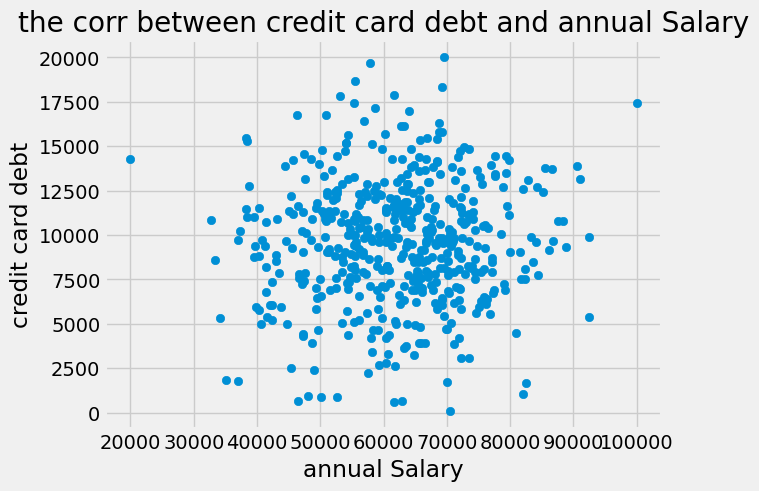

In [ ]:
plt.scatter(df['annual Salary'] , df['credit card debt'])
plt.xlabel('annual Salary')
plt.ylabel('credit card debt')
plt.title('the corr between credit card debt and annual Salary')

Menampilkan plot hubungan dari setiap data

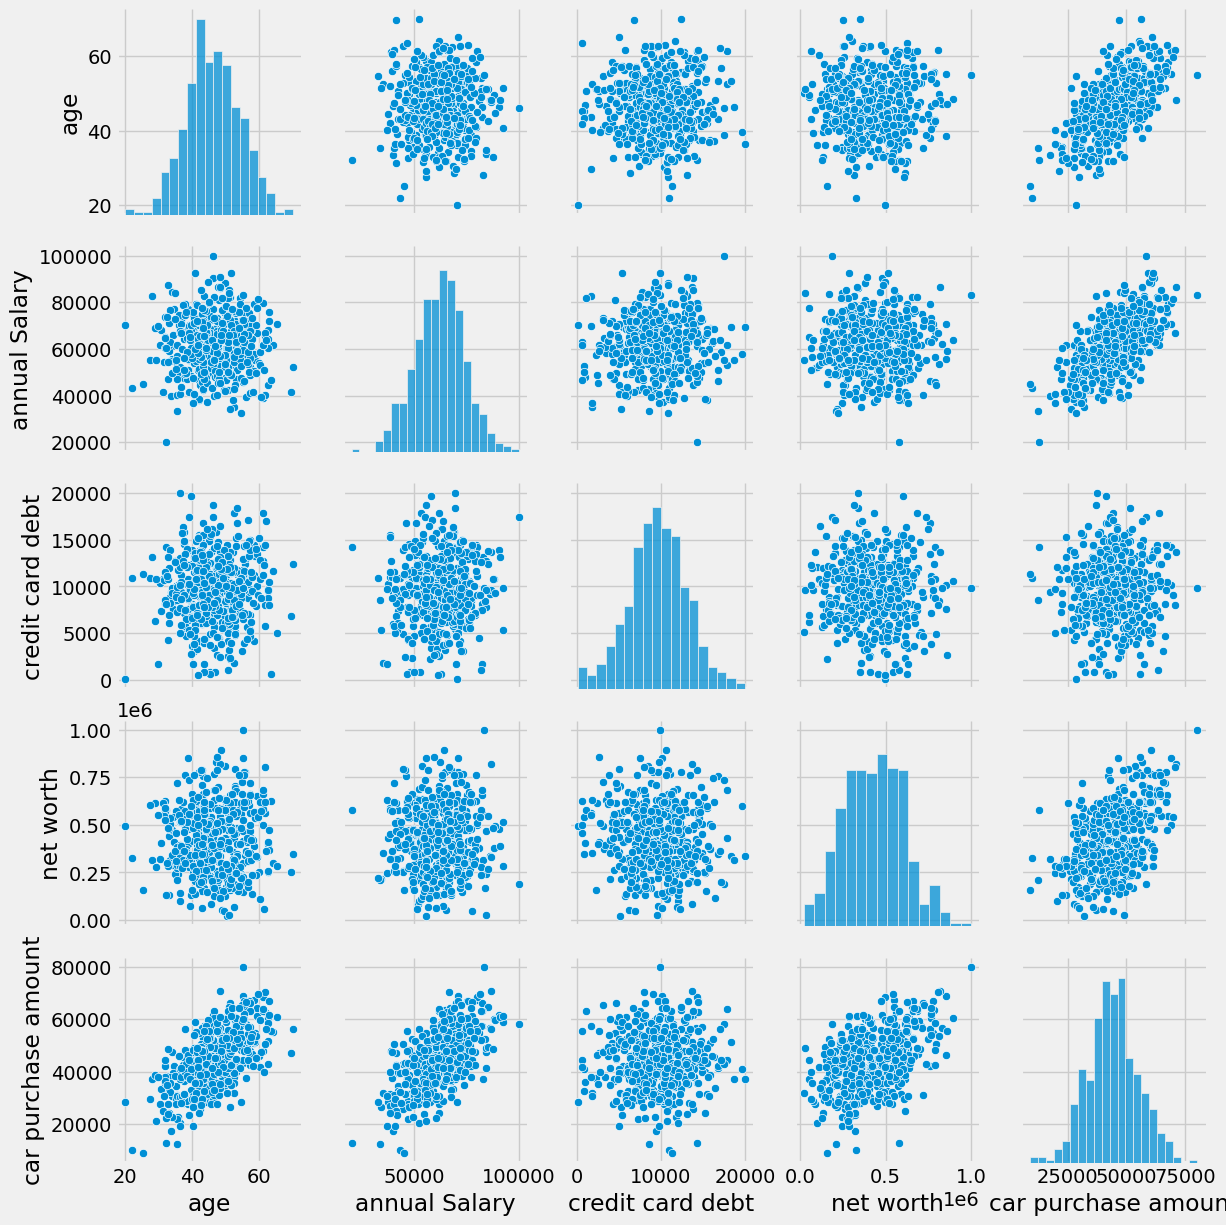

In [ ]:
sns.pairplot(df)

Mengambil data dari DataFrame df. Variabel X akan berisi semua kolom dari df kecuali kolom terakhir (kolom target).Variabel y akan berisi kolom terakhir dari df, yaitu kolom target.

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Preprocessing

Membagi data menjadi set train dan test

In [ ]:
scale = MinMaxScaler()
X = scale.fit_transform(X)
y = scale.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Linear regrssion

Test menggunakan regresi linier

In [ ]:
#Trying linear regression
lreg = LinearRegression()
lreg.fit(X_train, y_train)
print('Train score', lreg.score(X_train, y_train))
print('Test score', lreg.score(X_test, y_test))

Train score 0.9999999813297303
Test score 0.9999999803983576


Prediksi dengan menggunkan regresi linier

In [ ]:
y_pred = lreg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


# ANN Model

membuat ANN Model sequential dengan fungsi aktivasi relu

In [ ]:
ann = Sequential([Dense(32, activation="relu"),
                 Dense(1, activation='linear')])

ann.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_error'])


history = ann.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 1s 23ms/step - loss: 0.0170 - mean_absolute_error: 0.1033 - val_loss: 0.0090 - val_mean_absolute_error: 0.0748
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_absolute_error: 0.0826 - val_loss: 0.0074 - val_mean_absolute_error: 0.0674
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_absolute_error: 0.0705 - val_loss: 0.0065 - val_mean_absolute_error: 0.0623
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0640 - val_loss: 0.0052 - val_mean_absolute_error: 0.0557
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0588 - val_loss: 0.0041 - val_mean_absolute_error: 0.0502
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0552 - val_loss: 0.0037 - val_mean_absolute_error: 0.0484
Epoch 7/50
10/10 [=========

Plot "Training and Validation Loss" dan "Training and Validation Accuracy"


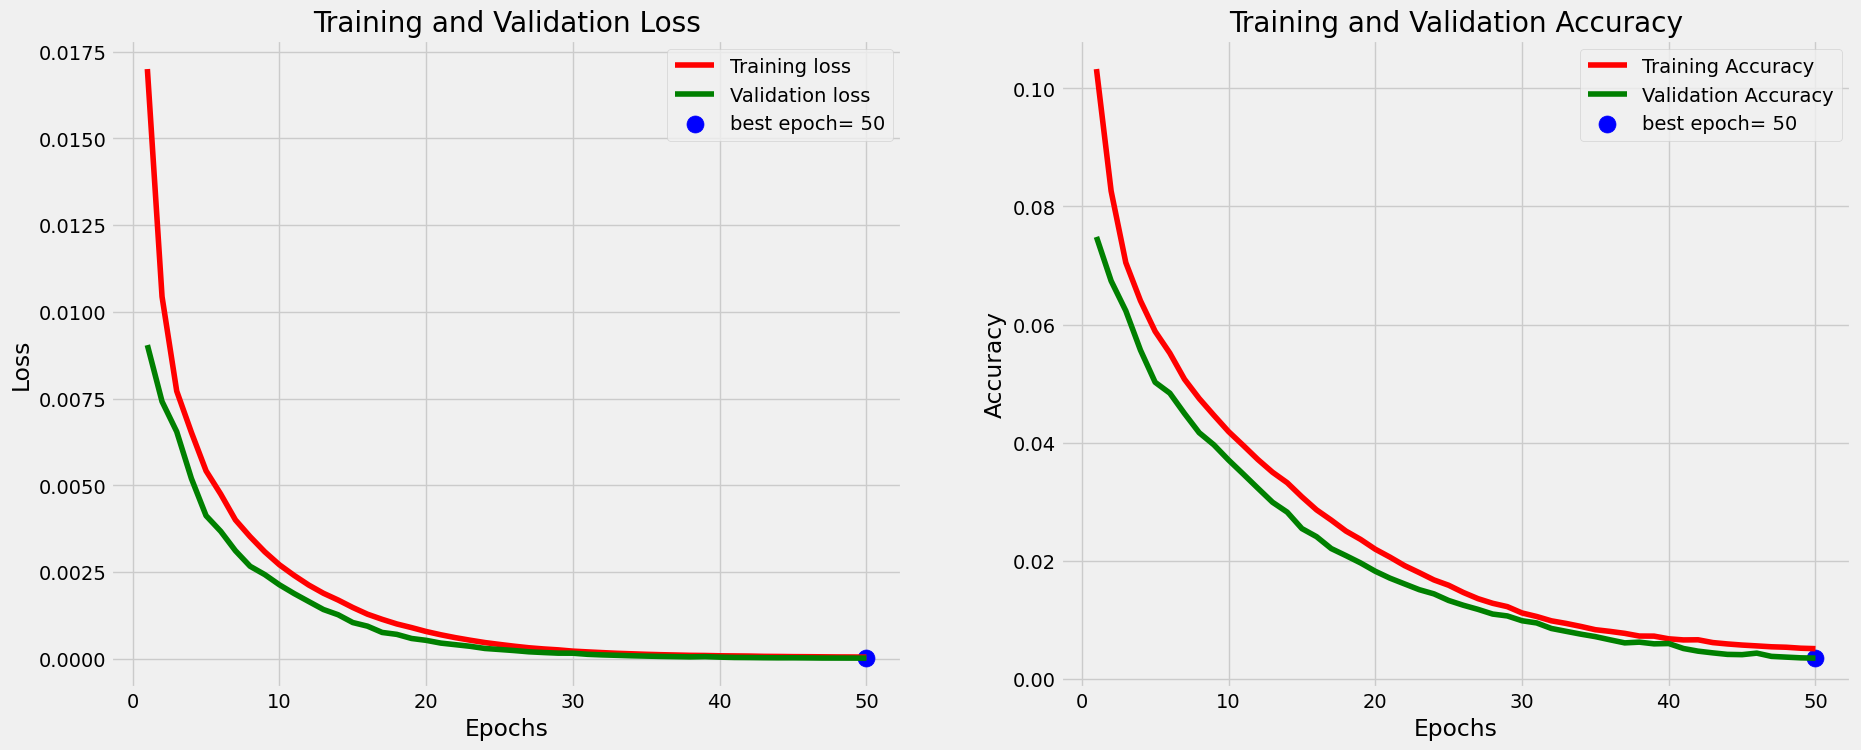

In [ ]:
tr_acc = history.history['mean_absolute_error']
tr_loss = history.history['loss']
val_acc = history.history['val_mean_absolute_error']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmin(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Memprediksi nilai target

In [ ]:
ann_y_pred = ann.predict(X_test)

3/3 [==============================] - 0s 4ms/step


Menunjukan skor r2-nya

In [ ]:
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

R2 score: 0.9999999803983576


mengevasluasi testnya

In [ ]:
ann.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 4.0146e-05 - mean_absolute_error: 0.0047


[4.0145692764781415e-05, 0.00466978270560503]

Prediksi nilai target pada fitur input yang diberikan: usia (40), pendapatan (70000.500), skor kredit (9550), dan jumlah pinjaman (534000)

In [ ]:
ann.predict([[40, 70000.500, 9550,534000]])

1/1 [==============================] - 0s 36ms/step


array([[239447.62]], dtype=float32)

Membandingkan nilai prediksi dengan nilai aktual

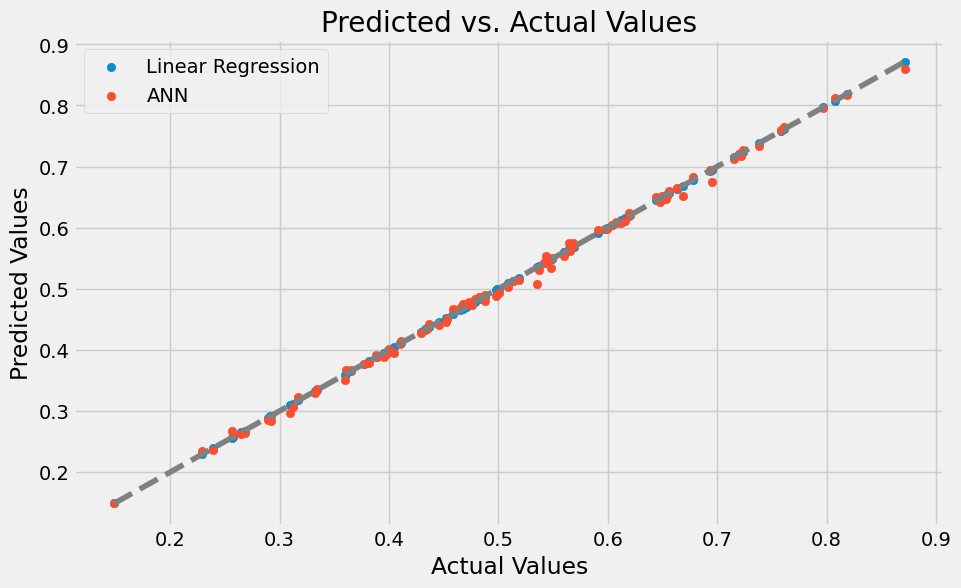

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='Linear Regression')
plt.scatter(y_test, ann_y_pred, label='ANN')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()

# ANN Model Baru

karena model sebelumnya menggunakan metode regresion, maka kita akan membuat metode baru agar dapat menampilkan confusion matrix dan clasification reportnya

In [ ]:

X = df.drop(columns=['car purchase amount'])
y = df['car purchase amount']

# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# pisahkan data menjadi train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

membuat ANN model

In [ ]:


model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

history = ann.fit(X_train, y_train, epochs=50, validation_split=0.2)



Epoch 1/50
10/10 [==============================] - 0s 13ms/step - loss: 2076121856.0000 - mean_absolute_error: 44200.2969 - val_loss: 1938619648.0000 - val_mean_absolute_error: 42924.7578
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 2076043008.0000 - mean_absolute_error: 44199.4297 - val_loss: 1938538496.0000 - val_mean_absolute_error: 42923.8320
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 2075956480.0000 - mean_absolute_error: 44198.4805 - val_loss: 1938452224.0000 - val_mean_absolute_error: 42922.8516
Epoch 4/50
10/10 [==============================] - 0s 7ms/step - loss: 2075863424.0000 - mean_absolute_error: 44197.4531 - val_loss: 1938357888.0000 - val_mean_absolute_error: 42921.7734
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 2075761280.0000 - mean_absolute_error: 44196.3281 - val_loss: 1938255488.0000 - val_mean_absolute_error: 42920.6016
Epoch 6/50
10/10 [==============================] - 0s 6ms/

latih program

In [ ]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


Membuat confusin matrix

In [ ]:
threshold = 45000  # Set a threshold for binary classification
y_pred_binary = (y_pred > threshold).astype(int)
cm = confusion_matrix(y_test > threshold, y_pred_binary)


Plot confusion matrix

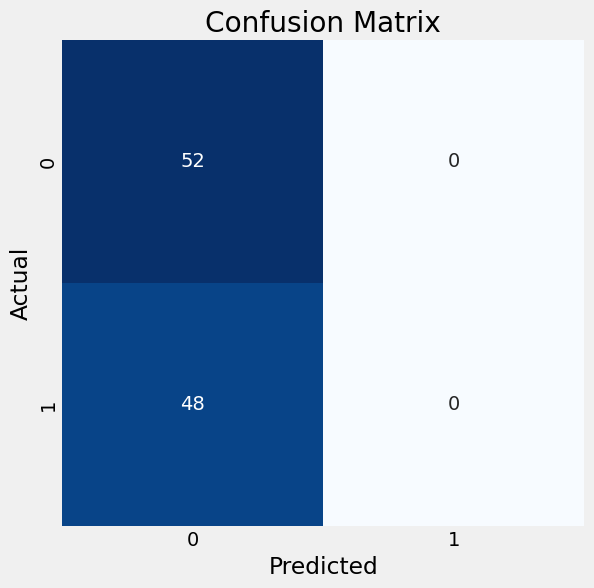

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Membuat classification reportnya

In [ ]:
print(classification_report(y_test > threshold, y_pred_binary))


              precision    recall  f1-score   support

       False       0.52      1.00      0.68        52
        True       0.00      0.00      0.00        48

    accuracy                           0.52       100
   macro avg       0.26      0.50      0.34       100
weighted avg       0.27      0.52      0.36       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
